In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as consts
import ugradio

## Sun - Short Time

In [18]:
npz = np.load('SunRun1final.npz')

In [19]:
volts = npz['volts']
time = npz['time']

In [25]:
time = time - time[0]

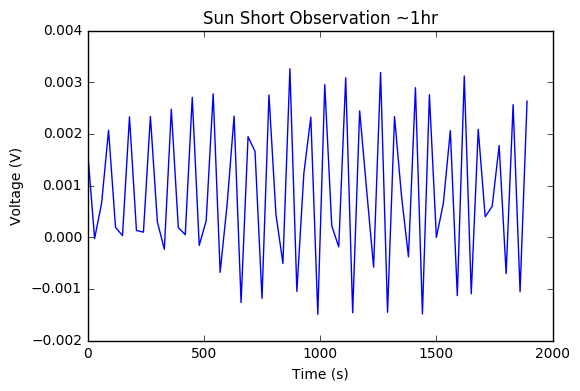

In [27]:
plt.plot(time, volts)
plt.title("Sun Short Observation ~1hr")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
#plt.savefig('SunShortVolts.pdf', bbox_inches='tight')
plt.savefig('SunShortVolts.png')
plt.show()

In [28]:
sunft = np.abs(np.fft.fft(volts))**2
sunfreqs = np.fft.fftfreq(len(volts), 15)

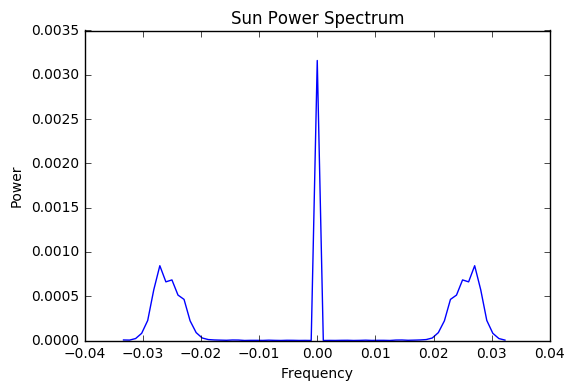

In [29]:
plt.plot(np.fft.fftshift(sunfreqs), np.fft.fftshift(sunft))
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.title("Sun Power Spectrum")
#plt.savefig('SunShortSpec.pdf', bbox_inches='tight')
plt.savefig('SunShortSpec.png')
plt.show()

Do these frequencies agree with the predicted values?

 H.A. = Local sidereal time - right ascension

In [9]:
unixtime = time
JDtime = ugradio.timing.julian_date(unixtime)
LSTtime = ugradio.timing.lst(jd = JDtime)

In [50]:
d = ugradio.coord.sunpos()[1]
ra = ugradio.coord.sunpos()[0]
l = consts.c/10.7e9
Bew = 20
Bns = 0
L = ugradio.coord.nch.lat
h = LSTtime - ra

In [51]:
Qew = (Bew*np.cos(d)/l)

In [52]:
Qns = (Bns*np.sin(L)*np.cos(d)/l)

In [53]:
ff = Qew*np.cos(h) - Qns*np.sin(h)

In [54]:
ffseconds = ff*2*np.pi/(60*60*24)

In [55]:
print(min(ffseconds), max(ffseconds))

(0.020850142522137672, 0.022565710413680721)


## Crab Nebula

Don't see evidence of Crab Nebula signal in FT

In [11]:
npz = np.load('Crab_Longfinal.npz')

In [12]:
crabvolts = npz['volts']
crabtimes = npz['time']

<IPython.core.display.Javascript object>


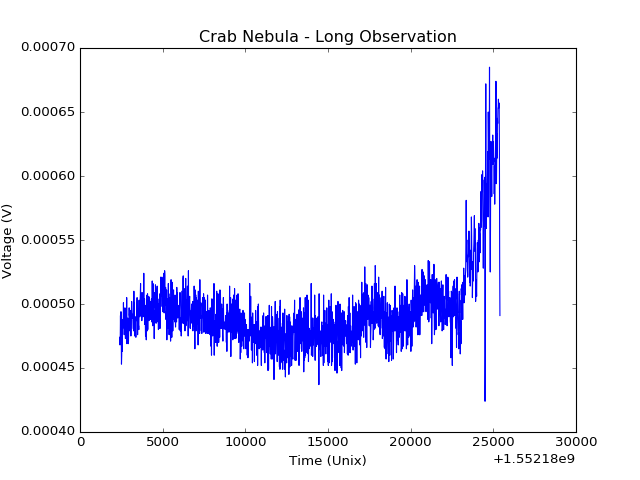

In [30]:
plt.plot(crabtimes, crabvolts)
plt.title("Crab Nebula - Long Observation")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (Unix)")
#plt.savefig('CrabVolts.pdf', bbox_inches='tight')
plt.savefig('CrabVolts.png')
plt.show()

In [15]:
crabft = np.abs(np.fft.fft(crabvolts))**2
crabfreqs = np.fft.fftfreq(len(crabvolts), 15)

<IPython.core.display.Javascript object>


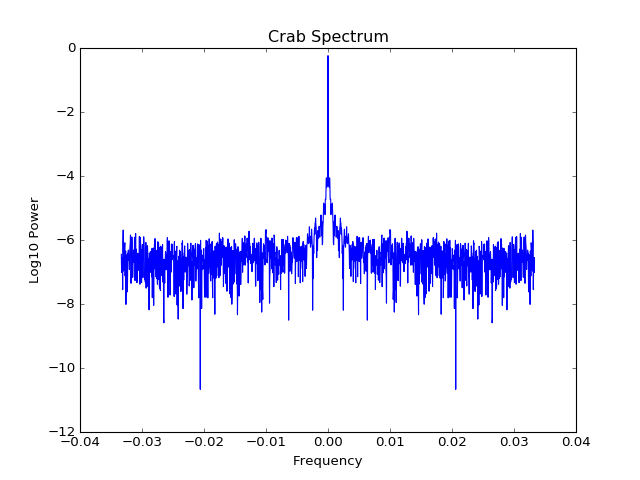

In [31]:
%matplotlib notebook
plt.plot(np.fft.fftshift(crabfreqs), np.log10(np.fft.fftshift(crabft)))
plt.title('Crab Spectrum')
plt.ylabel("Log10 Power")
plt.xlabel("Frequency")
#plt.savefig('CrabSpec.pdf', bbox_inches='tight')
plt.savefig('CrabSpec.png')
plt.show()

In [32]:
len(crabft)

1534

<IPython.core.display.Javascript object>


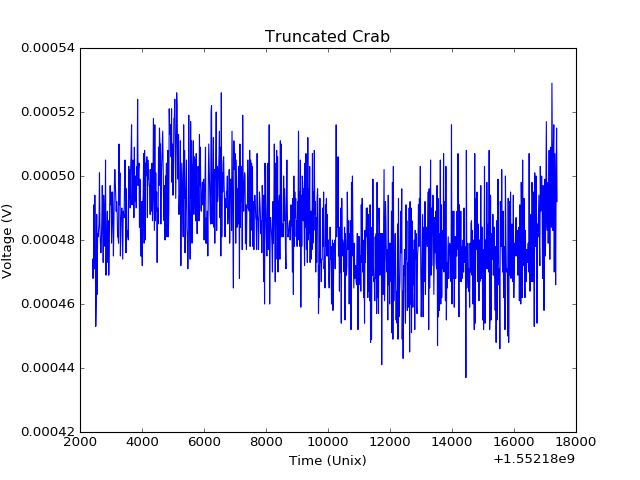

In [43]:
plt.plot(crabtimes[:1000], crabvolts[:1000])
plt.title('Truncated Crab')
plt.xlabel('Time (Unix)')
plt.ylabel('Voltage (V)')
plt.savefig('Trunkrab.png')
plt.show()

In [37]:
crabft1 = np.abs(np.fft.fft(crabvolts[0:1000]))**2
crabfreqs1 = np.fft.fftfreq(len(crabvolts[0:1000]), 15)

<IPython.core.display.Javascript object>


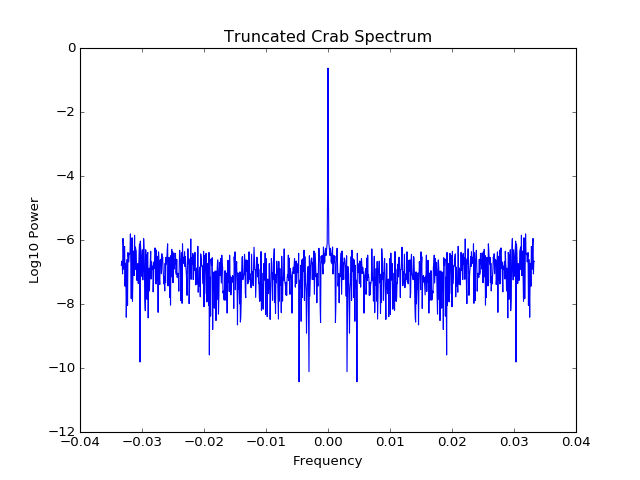

In [44]:
plt.plot(np.fft.fftshift(crabfreqs1), np.log10(np.fft.fftshift(crabft1)))
plt.title('Truncated Crab Spectrum')
plt.ylabel("Log10 Power")
plt.xlabel("Frequency")
#plt.savefig('CrabSpec.pdf', bbox_inches='tight')
plt.savefig('TrunkCrabSpec.png')
plt.show()